In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [15]:
#Counter for how many images skipped
num_skipped = 0

#Iterate both cat and dog images
for folder_name in ("Cat", "Dog"):
    #Get folder path for images folders
    folder_path = os.path.join("PetImages", folder_name)

    #File name for each image in folder
    for file_name in os.listdir(folder_path):
        #Get image path for every image
        file_path = os.path.join(folder_path, file_name)

        try:
            #Open image
            file_object = open(file_path, "rb")
            #Check if image contains JFIF in the first 10 bytes???
            is_jfif = tf.compat.as_bytes("JFIF") in file_object.peek(10)
        finally:
            file_object.close()

        if not is_jfif:
            num_skipped += 1

            os.remove(file_path)
print("Deleted " + str(num_skipped) + " iamges")

Deleted 0 iamges


In [16]:
image_size = (180, 180)
batch_size = 128

#Select random images from the pet images folder and create train and validation data
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


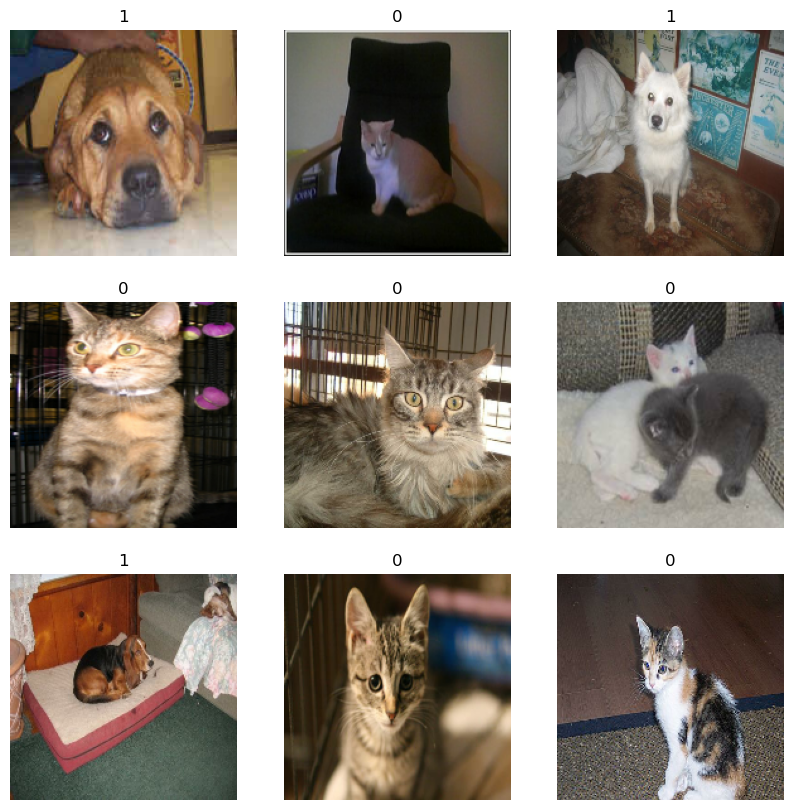

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

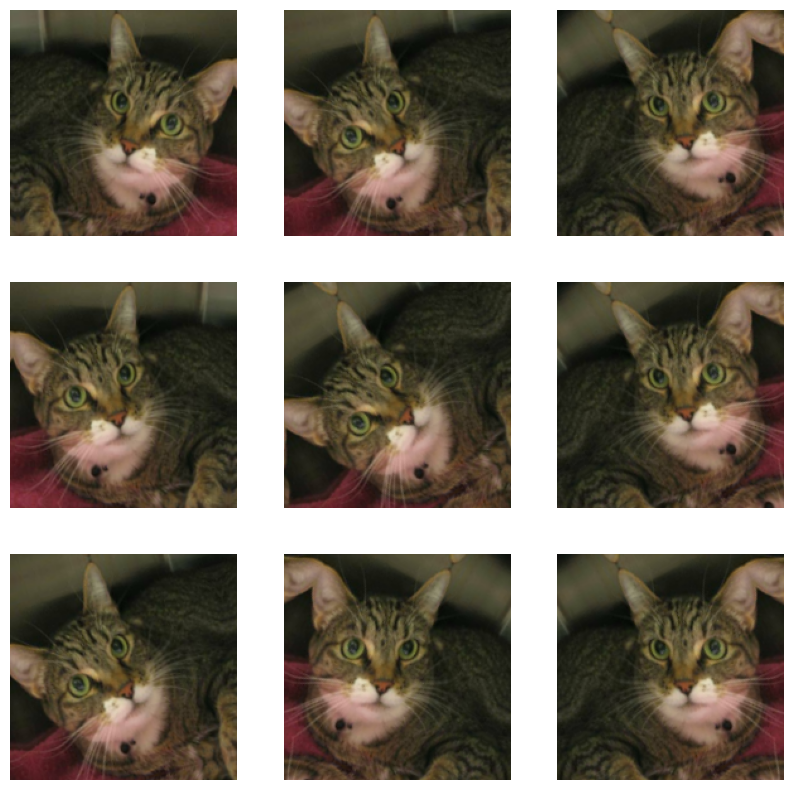

In [18]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),])
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
#Apply augmentation to training images

train_ds = train_ds.map(
    lambda image, label: (data_augmentation(image), label),
    num_parallel_calls = tf.data.AUTOTUNE,
)

#Prefetching the samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [23]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    #Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3 , strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    #Set aside residual
    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 180, 180, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 90, 90, 128)  3584        ['rescaling_2[0][0]']            
                                                                                                  
 batch_normalization_16 (BatchN  (None, 90, 90, 128)  512        ['conv2d_8[0][0]']         

In [33]:
tf.config.list_physical_devices('GPU')

[]

In [34]:
epochs = 25

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")],

model.compile(
    optimizer = keras.optimizers.Adam(0.0001),
    loss = "binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_ds
)

Epoch 1/25
  2/147 [..............................] - ETA: 17:01 - loss: 0.5950 - accuracy: 0.6836

KeyboardInterrupt: 